## Import

In [1]:
import pandas as pd
import numpy as np
import random
import os

from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Data Load

In [3]:
train = pd.read_csv('./train.csv')

In [4]:
train

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...,...
987995,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,20230530,A000540,흥국화재,50218,3250,3255,3195,3215
987997,20230530,A003280,흥아해운,130664,1344,1395,1340,1370
987998,20230530,A037440,희림,141932,9170,9260,9170,9200


In [6]:
# train_close = train[train['종목코드'] == code][['일자', '종가']]
# train_close['일자'] = pd.to_datetime(train_close['일자'], format='%Y%m%d')
# train_close.set_index('일자', inplace=True)
# tc = train_close['종가']
# print(tc._index.start, tc._index.end)
import statsmodels
print(statsmodels.__version__)

0.13.5


## Model Define, Train and Inference

In [9]:
# 추론 결과를 저장하기 위한 dataframe 생성
results_df = pd.DataFrame(columns=['종목코드', 'final_return'])

# train 데이터에 존재하는 독립적인 종목코드 추출
unique_codes = train['종목코드'].unique()

# 각 종목코드에 대해서 모델 학습 및 추론 반복
for code in tqdm(unique_codes):
    
    # 학습 데이터 생성
    train_close = train[train['종목코드'] == code][['일자', '종가']]
    train_close['일자'] = pd.to_datetime(train_close['일자'], format='%Y%m%d')
    train_close.set_index('일자', inplace=True)
    tc = train_close['종가']
    
    # 모델 선언, 학습 및 추론
    model = ARIMA(tc, order=(2, 1, 2))
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=15) # 향후 15개의 거래일에 대해서 예측
    
    # 최종 수익률 계산
    final_return = (predictions.iloc[-1] - predictions.iloc[0]) / predictions.iloc[0]
    
    # 결과 저장
    results_df = results_df.append({'종목코드': code, 'final_return': final_return}, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [29:41<00:00,  1.12it/s]


In [10]:
results_df['순위'] = results_df['final_return'].rank(method='first', ascending=False).astype('int') # 각 순위를 중복없이 생성
results_df

,종목코드,final_return,순위
0,A060310,-0.056264,1992
1,A095570,-0.002943,1689
2,A006840,0.003040,350
3,A054620,0.001876,480
4,A265520,0.002090,447
...,...,...,...
1995,A189980,0.000630,729
1996,A000540,0.002514,394
1997,A003280,0.001430,547
1998,A037440,0.000880,653


## Submit

In [11]:
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission

,종목코드,순위
0,A000020,1
1,A000040,2
2,A000050,3
3,A000070,4
4,A000080,5
...,...,...
1995,A375500,1996
1996,A378850,1997
1997,A383220,1998
1998,A383310,1999


In [12]:
baseline_submission = sample_submission[['종목코드']].merge(results_df[['종목코드', '순위']], on='종목코드', how='left')
baseline_submission

,종목코드,순위
0,A000020,493
1,A000040,1655
2,A000050,868
3,A000070,1078
4,A000080,1205
...,...,...
1995,A375500,752
1996,A378850,553
1997,A383220,614
1998,A383310,241


In [13]:
baseline_submission.to_csv('baseline_submission.csv', index=False)

##  LSTM

In [21]:
train.index = train['일자']

In [22]:
train

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
일자,,,,,,,,
20210601,20210601,A060310,3S,166690,2890,2970,2885,2920
20210601,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
20210601,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
20210601,20210601,A054620,APS,462544,14600,14950,13800,14950
20210601,20210601,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...,...
20230530,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
20230530,20230530,A000540,흥국화재,50218,3250,3255,3195,3215
20230530,20230530,A003280,흥아해운,130664,1344,1395,1340,1370


In [51]:
from sklearn.preprocessing import StandardScaler

train_close = train[train['종목코드'] == code][['일자', '종가','거래량']]
train_close['일자'] = pd.to_datetime(train_close['일자'], format='%Y%m%d')
train_close.set_index('일자', inplace=True)
tc = train_close[['종가', '거래량']]
print(tc)
scaler = StandardScaler()
scaler = scaler.fit(tc)
stock_data_scaled = scaler.transform(tc)

               종가      거래량
일자                        
2021-06-01  11500   106454
2021-06-02  11400    55933
2021-06-03  11550    78144
2021-06-04  11750    86093
2021-06-07  11750    58979
...           ...      ...
2023-05-23   6430    40981
2023-05-24   6320    19392
2023-05-25   6330     6457
2023-05-26   6330     8905
2023-05-30   8220  2611843

[494 rows x 2 columns]


In [28]:
pd.DataFrame(stock_data_scaled)

,0,1,2,3,4
0,-0.125361,-0.348772,-0.349477,-0.347262,-0.350426
1,-0.146612,-0.303709,-0.305081,-0.303119,-0.307008
2,-0.138378,0.146005,0.138279,0.134457,0.127479
3,-0.064233,-0.171101,-0.170399,-0.179088,-0.167796
4,-0.132531,0.049660,0.041864,0.052026,0.046260
...,...,...,...,...,...
987995,-0.103544,-0.347027,-0.348505,-0.346183,-0.349515
987996,-0.149426,-0.343310,-0.345217,-0.342486,-0.345947
987997,-0.132805,-0.372229,-0.373020,-0.371067,-0.373957
987998,-0.130476,-0.253488,-0.255454,-0.250425,-0.255088


In [32]:
n_train = int(0.9*stock_data_scaled.shape[0])
train_data_scaled = stock_data_scaled[0: n_train]
train_dates = train['일자'][0: n_train]

test_data_scaled = stock_data_scaled[n_train:]
test_dates = train['일자'][n_train:]

In [33]:
pred_days = 1  # prediction period
seq_len = 14   # sequence length = past days for future prediction.
input_dim = 5  # input_dimension = ['Open', 'High', 'Low', 'Close', 'Volume']

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

In [35]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), 
               return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(trainY.shape[1]))

Using TensorFlow backend.


In [37]:
from tensorflow.keras.optimizers import Adam

# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

In [39]:
import matplotlib.pyplot as plt

# Try to load weights
try:
    model.load_weights('./save_weights/lstm_weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)
    # Save model weights after training
    model.save_weights('./save_weights/lstm_weights.h5')

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()


No weights found, training model from scratch
Train on 800267 samples, validate on 88919 samples
Epoch 1/30
800267/800267 [==============================] - 882s 1ms/step - loss: 1.0197 - val_loss: 0.5330
Epoch 2/30
800267/800267 [==============================] - 392s 490us/step - loss: 1.0185 - val_loss: 0.5340
Epoch 3/30
800267/800267 [==============================] - 392s 490us/step - loss: 1.0181 - val_loss: 0.5332
Epoch 4/30
800267/800267 [==============================] - 393s 492us/step - loss: 1.0179 - val_loss: 0.5320
Epoch 5/30
800267/800267 [==============================] - 396s 495us/step - loss: 1.0179 - val_loss: 0.5316
Epoch 6/30
800267/800267 [==============================] - 421s 527us/step - loss: 1.0178 - val_loss: 0.5337
Epoch 7/30
800267/800267 [==============================] - 407s 509us/step - loss: 1.0174 - val_loss: 0.5317
Epoch 8/30
800267/800267 [==============================] - 399s 499us/step - loss: 1.0178 - val_loss: 0.5365
Epoch 9/30
800267/800267 

OSError: Unable to create file (unable to open file: name = './save_weights/lstm_weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [45]:
# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)
print(prediction)
# generate array filled with means for prediction
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

# substitute predictions into the first column
mean_values_pred[:, 0] = np.squeeze(prediction)

(98786, 1) (98786, 1)
[[-0.03213018]
 [-0.03213018]
 [-0.03213018]
 ...
 [-0.03213018]
 [-0.03213018]
 [-0.03213018]]


In [41]:
# inverse transform
y_pred = scaler.inverse_transform(mean_values_pred)[:,0]
print(y_pred.shape)

# generate array filled with means for testY
mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# substitute testY into the first column
mean_values_testY[:, 0] = np.squeeze(testY)

# inverse transform
testY_original = scaler.inverse_transform(mean_values_testY)[:,0]
print(testY_original.shape)

(98786,)
(98786,)


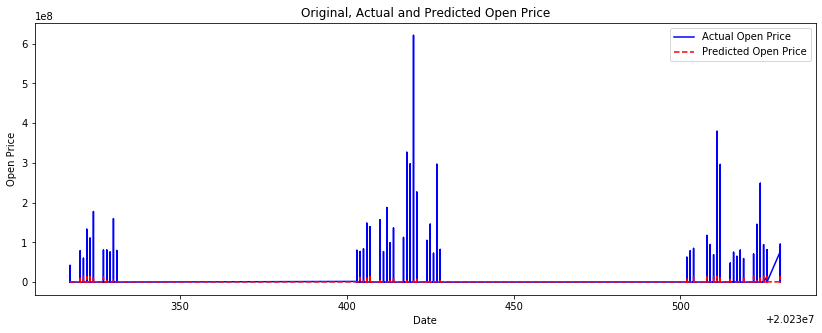

In [44]:
# plotting
plt.figure(figsize=(14, 5))

# plot original 'Open' prices
# plt.plot(train['일자'], original_open, color='green', label='Original Open Price')

# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Open Price')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Open Price')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Original, Actual and Predicted Open Price')
plt.legend()
plt.show()

In [62]:
# 추론 결과를 저장하기 위한 dataframe 생성
results_df = pd.DataFrame(columns=['종목코드', 'final_return'])

# train 데이터에 존재하는 독립적인 종목코드 추출
unique_codes = train['종목코드'].unique()

# 각 종목코드에 대해서 모델 학습 및 추론 반복
for code in tqdm(unique_codes):
    '''
    # 학습 데이터 생성
    train_close = train[train['종목코드'] == code][['일자', '종가']]
    train_close['일자'] = pd.to_datetime(train_close['일자'], format='%Y%m%d')
    train_close.set_index('일자', inplace=True)
    tc = train_close['종가']
    '''
    # 학습데이터 생성
    from sklearn.preprocessing import StandardScaler
    
    train_close = train[train['종목코드'] == code][['일자', '종가','거래량', '시가', '고가', '저가']]
    train_close['일자'] = pd.to_datetime(train_close['일자'], format='%Y%m%d')
    train_close.set_index('일자', inplace=True)
    tc = train_close[['종가', '거래량', '시가', '고가', '저가']]
   
    scaler = StandardScaler()
    scaler = scaler.fit(tc)
    stock_data_scaled = scaler.transform(tc)
    
    #
    n_train = int(1*stock_data_scaled.shape[0])
    train_data_scaled = stock_data_scaled[0: n_train]
    train_dates = train['일자'][0: n_train]

    test_data_scaled = stock_data_scaled[n_train:]
    test_dates = train['일자'][n_train:]
    
    ##
    pred_days = 1  # prediction period
    seq_len = 14   # sequence length = past days for future prediction.
    input_dim = 5  # input_dimension = ['Open', 'High', 'Low', 'Close', 'Volume']

    trainX = []
    trainY = []
    testX = []
    testY = []

    for i in range(seq_len, n_train-pred_days +1):
        trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
        trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

    for i in range(seq_len, len(test_data_scaled)-pred_days +1):
        testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
        testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)
    testX, testY = np.array(testX), np.array(testY)
    
    ###
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    
    model = Sequential()
    model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), 
                   return_sequences=True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(trainY.shape[1]))
    
    ####
    from tensorflow.keras.optimizers import Adam

    # specify your learning rate
    learning_rate = 0.01
    # create an Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    # compile your model using the custom optimizer
    model.compile(optimizer=optimizer, loss='mse')
    
    ########
    # prediction
#     prediction = model.predict(testX)
#     print(prediction.shape, testY.shape)
#     print(prediction)
    # generate array filled with means for prediction
#     mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

#     # substitute predictions into the first column
#     mean_values_pred[:, 0] = np.squeeze(prediction)
    
    
    ##########
    # inverse transform
    y_pred = scaler.inverse_transform(mean_values_pred)[:,0]
    predictions = model_fit.forecast(steps=15)
    final_return = (predictions.iloc[-1] - predictions.iloc[0]) / predictions.iloc[0]
    results_df = results_df.append({'종목코드': code, 'final_return': final_return}, ignore_index=True)
#     print(y_pred)

    '''
    # 모델 선언, 학습 및 추론
     model = ARIMA(tc, order=(2, 1, 2))
     model_fit = model.fit()
     predictions = model_fit.forecast(steps=15) # 향후 15개의 거래일에 대해서 예측
    
    # 최종 수익률 계산
    final_return = (predictions.iloc[-1] - predictions.iloc[0]) / predictions.iloc[0]
    
    # 결과 저장
    results_df = results_df.append({'종목코드': code, 'final_return': final_return}, ignore_index=True)
    '''

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [18:34<00:00,  1.80it/s]


In [63]:
results_df['순위'] = results_df['final_return'].rank(method='first', ascending=False).astype('int') # 각 순위를 중복없이 생성
results_df

,종목코드,final_return,순위
0,A060310,0.010894,1
1,A095570,0.010894,2
2,A006840,0.010894,3
3,A054620,0.010894,4
4,A265520,0.010894,5
...,...,...,...
1995,A189980,0.010894,1996
1996,A000540,0.010894,1997
1997,A003280,0.010894,1998
1998,A037440,0.010894,1999


In [64]:
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission

,종목코드,순위
0,A000020,1
1,A000040,2
2,A000050,3
3,A000070,4
4,A000080,5
...,...,...
1995,A375500,1996
1996,A378850,1997
1997,A383220,1998
1998,A383310,1999


In [65]:
baseline_submission = sample_submission[['종목코드']].merge(results_df[['종목코드', '순위']], on='종목코드', how='left')
baseline_submission

,종목코드,순위
0,A000020,503
1,A000040,119
2,A000050,244
3,A000070,761
4,A000080,1804
...,...,...
1995,A375500,36
1996,A378850,1956
1997,A383220,49
1998,A383310,1130


In [66]:
baseline_submission.to_csv('lstm_submission.csv', index=False)